Grafos

En este proyecto debe escribir una función `camino(Grafo, nodo1,nodo2)` que construya el camino más económico usando el algoritmo codicioso de Dijkstra a dos pasos.

Considere por ejemplo el siguiente grafo:

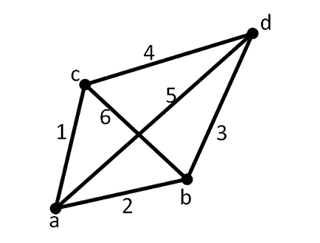

Supongamos que queremos calcular el camino más económico desde a hasta d. En este caso hay cinco caminos posibles con costos:
+ a-b-d. Costo =5
+ a-c-d. Costo =5
+ a-b-c-d. Costo = 12
+ a-c-b-d. Costo = 10
+ a-d. Costo = 5

Note que el primer nodo está fijo: a, pero el segundo nodo tiene 3 posibilidades, el tercero dos y así sucesivamente. Es decir que en un grafo completo de $n$ nodos hay $(n-1)!$ caminos posibles.

Su función `caminos(nodo1, nodo2)` va a calcular todas las parejas de nodos y va a tomar la más económica. Por ejemplo:

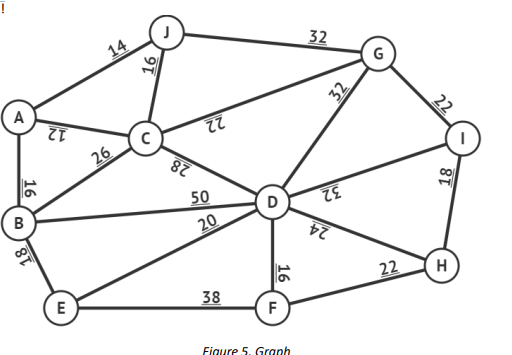

Si queremos calcular `camino(G, "A", "H")` su función debe considerar todas las parejas:
+ A-J-G
+ A-J-C
+ A-C-J
+ A-C-G
+ A-B-E
+ A-B-C
+ A-B-D
y esoger la pareja más económica. Luego seguir así hasta llegar al nodo deseado "H".

Sun función `camino("A", "H")` debe retornar el costo y el camino más económico usando este algoritmo.

**Bono:** Haga una animación de la busqueda de caminos.

**Más Bonos:** Compare su respuesta con el camino más económico.

In [1]:
#@title Clase de grafos.
# Copyright 2013, Michael H. Goldwasser
#
# Developed for use with the book:
#
#    Data Structures and Algorithms in Python
#    Michael T. Goodrich, Roberto Tamassia, and Michael H. Goldwasser
#    John Wiley & Sons, 2013
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

class Graph:
  """Representation of a simple graph using an adjacency map."""

  #------------------------- nested Vertex class -------------------------
  class Vertex:
    """Lightweight vertex structure for a graph."""
    __slots__ = '_element'

    def __init__(self, x):
      """Do not call constructor directly. Use Graph's insert_vertex(x)."""
      self._element = x

    def element(self):
      """Return element associated with this vertex."""
      return self._element

    def __hash__(self):         # will allow vertex to be a map/set key
      return hash(id(self))

    def __str__(self):
      return str(self._element)

  #------------------------- nested Edge class -------------------------
  class Edge:
    """Lightweight edge structure for a graph."""
    __slots__ = '_origin', '_destination', '_element'

    def __init__(self, u, v, x):
      """Do not call constructor directly. Use Graph's insert_edge(u,v,x)."""
      self._origin = u
      self._destination = v
      self._element = x

    def endpoints(self):
      """Return (u,v) tuple for vertices u and v."""
      return (self._origin, self._destination)

    def opposite(self, v):
      """Return the vertex that is opposite v on this edge."""
      if not isinstance(v, Graph.Vertex):
        raise TypeError('v must be a Vertex')
      return self._destination if v is self._origin else self._origin
      raise ValueError('v not incident to edge')

    def element(self):
      """Return element associated with this edge."""
      return self._element

    def __hash__(self):         # will allow edge to be a map/set key
      return hash( (self._origin, self._destination) )

    def __str__(self):
      return '({0},{1},{2})'.format(self._origin,self._destination,self._element)

  #------------------------- Graph methods -------------------------
  def __init__(self, directed=False):
    """Create an empty graph (undirected, by default).

    Graph is directed if optional paramter is set to True.
    """
    self._outgoing = {}
    # only create second map for directed graph; use alias for undirected
    self._incoming = {} if directed else self._outgoing

  def _validate_vertex(self, v):
    """Verify that v is a Vertex of this graph."""
    if not isinstance(v, self.Vertex):
      raise TypeError('Vertex expected')
    if v not in self._outgoing:
      raise ValueError('Vertex does not belong to this graph.')

  def is_directed(self):
    """Return True if this is a directed graph; False if undirected.

    Property is based on the original declaration of the graph, not its contents.
    """
    return self._incoming is not self._outgoing # directed if maps are distinct

  def vertex_count(self):
    """Return the number of vertices in the graph."""
    return len(self._outgoing)

  def vertices(self):
    """Return an iteration of all vertices of the graph."""
    return self._outgoing.keys()

  def edge_count(self):
    """Return the number of edges in the graph."""
    total = sum(len(self._outgoing[v]) for v in self._outgoing)
    # for undirected graphs, make sure not to double-count edges
    return total if self.is_directed() else total // 2

  def edges(self):
    """Return a set of all edges of the graph."""
    result = set()       # avoid double-reporting edges of undirected graph
    for secondary_map in self._outgoing.values():
      result.update(secondary_map.values())    # add edges to resulting set
    return result

  def get_edge(self, u, v):
    """Return the edge from u to v, or None if not adjacent."""
    self._validate_vertex(u)
    self._validate_vertex(v)
    return self._outgoing[u].get(v)        # returns None if v not adjacent

  def degree(self, v, outgoing=True):
    """Return number of (outgoing) edges incident to vertex v in the graph.

    If graph is directed, optional parameter used to count incoming edges.
    """
    self._validate_vertex(v)
    adj = self._outgoing if outgoing else self._incoming
    return len(adj[v])

  def incident_edges(self, v, outgoing=True):
    """Return all (outgoing) edges incident to vertex v in the graph.

    If graph is directed, optional parameter used to request incoming edges.
    """
    self._validate_vertex(v)
    adj = self._outgoing if outgoing else self._incoming
    for edge in adj[v].values():
      yield edge

  def insert_vertex(self, x=None):
    """Insert and return a new Vertex with element x."""
    v = self.Vertex(x)
    self._outgoing[v] = {}
    if self.is_directed():
      self._incoming[v] = {}        # need distinct map for incoming edges
    return v

  def insert_edge(self, u, v, x=None):
    """Insert and return a new Edge from u to v with auxiliary element x.

    Raise a ValueError if u and v are not vertices of the graph.
    Raise a ValueError if u and v are already adjacent.
    """
    if self.get_edge(u, v) is not None:      # includes error checking
      raise ValueError('u and v are already adjacent')
    e = self.Edge(u, v, x)
    self._outgoing[u][v] = e
    self._incoming[v][u] = e

In [2]:
g = Graph()
# CREAR LOS NODOS
A = g.insert_vertex("A")
B = g.insert_vertex("B")
C = g.insert_vertex("C")
D = g.insert_vertex("D")
E = g.insert_vertex("E")
F = g.insert_vertex("F")
G = g.insert_vertex("G")
H = g.insert_vertex("H")
I = g.insert_vertex("I")
J = g.insert_vertex("J")

#CREAR LAS ARISTAS
# ARISTAS DE A
g.insert_edge(A,B,16)
g.insert_edge(A,C,12)
g.insert_edge(A,J,14)

#ARISTAS DE B
g.insert_edge(B,C,26)
g.insert_edge(B,D,50)
g.insert_edge(B,E,18)
#ARISTAS DE C
g.insert_edge(C,J,16)
g.insert_edge(C,G,22)
g.insert_edge(C,D,28)
#ARISTAS DE D
g.insert_edge(D,G,32)
g.insert_edge(D,I,32)
g.insert_edge(D,F,16)
g.insert_edge(D,E,20)
#ARISTAS DE E
g.insert_edge(E,F,38)
#ARISTAS DE F
g.insert_edge(F,H,22)
#ARISTAS DE G
g.insert_edge(G,I,22)
g.insert_edge(G,J,32)
#ARISTAS DE H
g.insert_edge(H,D,24)
g.insert_edge(H,I,18)


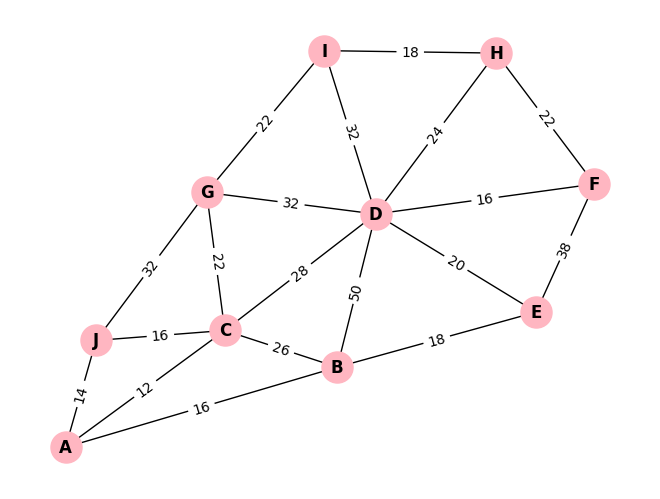

In [3]:
# Representación del grafo
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

for vertex in g.vertices():
    G.add_node(vertex.element())

for edge in g.edges():
    u, v = edge.endpoints()
    peso = edge.element() # Obtener el peso asignado a la arista
    G.add_edge(u.element(),
               v.element(),
               weight=peso) # Agregar el peso obtenido

pos = nx.spring_layout(G)
nx.draw(G,
        pos,
        with_labels=True,
        node_size=500,
        node_color='lightpink',
        font_size=12,
        font_weight='bold')

labels_aristas = nx.get_edge_attributes(G,
                                        'weight')
nx.draw_networkx_edge_labels(G,
                             pos,
                             edge_labels=labels_aristas)

plt.show()

In [4]:
def dijkstra_2_pasos(Grafo, Nodo1, Nodo2, visitados=None, camino_recorrido=None, costo=0):
    # Si visitados no se proporciona, se inicializa con el Nodo1
    if visitados == None:
        visitados = [Nodo1]

    # Variables para almacenar el camino más corto y su suma
    camin_corto = None
    suma_corto = None

    # Primer paso
    for i in Grafo.incident_edges(Nodo1):
        nodo_opuesto = i.opposite(Nodo1)  # Nodo opuesto a Nodo1 en la arista actual
        if nodo_opuesto is Nodo2 and i.element() < suma_corto:
            suma_corto = i.element()
            camin_corto = [nodo_opuesto]
        if not nodo_opuesto in visitados:
            peso_arista = i.element()  # Peso de la arista
            # Segundo paso
            for k in Grafo.incident_edges(nodo_opuesto):
                sig_nodo_opuesto = k.opposite(nodo_opuesto)  # Siguiente nodo opuesto en la arista
                if not sig_nodo_opuesto in visitados:
                    suma = i.element() + k.element()  # Suma de distancias
                    if suma_corto == None or suma < suma_corto:
                        suma_corto = suma
                        camin_corto = [nodo_opuesto, sig_nodo_opuesto]

    # Inicialización del camino recorrido si no se proporciona
    if camino_recorrido == None:
        camino_recorrido = [Nodo1]
    camino_recorrido += camin_corto

    # Si el último nodo del camino recorrido es el Nodo2, se ha encontrado el camino más corto
    if camino_recorrido[-1] is Nodo2:
        # Imprimir el camino más corto y su costo total
        print("El camino más corto es :")
        print(camino_recorrido[0].element(), end='')
        for nodo in camino_recorrido[1:]:
            print(' -->', nodo.element(), end='')
        print('\nCon un costo recorrido total de', costo + suma_corto)
        return camino_recorrido
    else:
        # Extender la lista de nodos visitados con el camino más corto y llamar recursivamente
        visitados.extend(camin_corto)
        return dijkstra_2_pasos(Grafo, camino_recorrido[-1], Nodo2, visitados=visitados, camino_recorrido=camino_recorrido, costo=costo + suma_corto)


# Llamada inicial a la función dijkstra_2_pasos
camino = dijkstra_2_pasos(g, A, H)


El camino más corto es :
A --> C --> J --> G --> I --> H
Con un costo recorrido total de 100


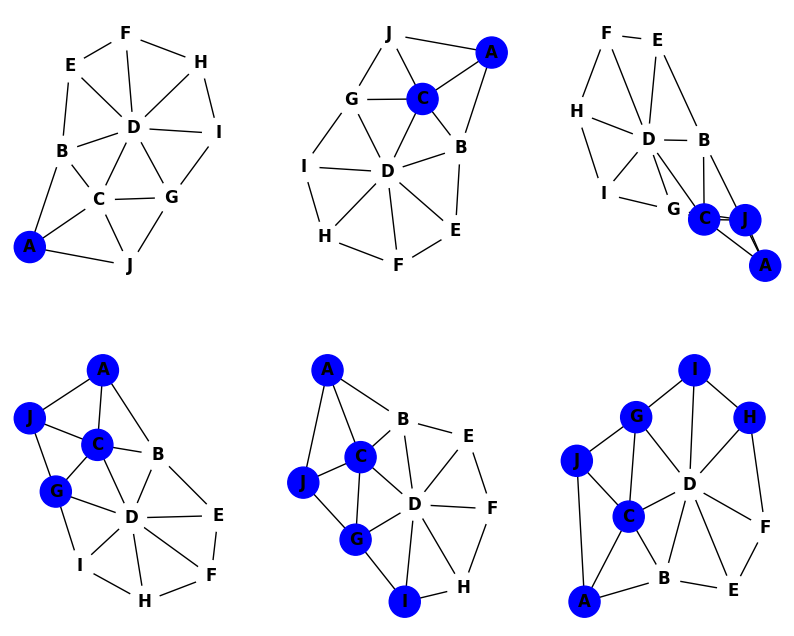

In [5]:
# Representación del grafo
import networkx as nx
import matplotlib.pyplot as plt
import math

G = nx.Graph()
n_cols = math.ceil(len(camino)**0.5)
n_rows = math.floor(len(camino)**0.5)
labels_aristas = nx.get_edge_attributes(G,
                                          'weight')
fig = plt.figure(figsize=(10,8))
axs = fig.subplots(n_rows, n_cols)

for ax, i in zip(axs.flatten(), range(len(camino))):
  for vertex in g.vertices():
      G.add_node(vertex.element())

  for edge in g.edges():
      u, v = edge.endpoints()
      peso = edge.element() # Obtener el peso asignado a la arista
      G.add_edge(u.element(),
                v.element(),
                weight=peso) # Agregar el peso obtenido


  str_camino = [n.element() for n in camino]
  color_map = []
  for node in G:
      if node in str_camino[:i+1]:
          color_map.append('blue')
      else:
          color_map.append('white')
  # nx.draw(G, node_color=color_map, with_labels=True)
  # plt.show()

  pos = nx.spring_layout(G)
  nx.draw(G,
          pos,
          with_labels=True,
          node_size=500,
          node_color=color_map,
          font_size=12,
          font_weight='bold',
          ax=ax)

  nx.draw_networkx_edge_labels(G,
                              pos,
                              edge_labels=labels_aristas.copy())

plt.show()